# Graph Coloring Using Grover's Search (Maxinum 4 Colors)

In [1]:
import warnings
warnings.filterwarnings("ignore")

## Problem Definition

In [2]:
import networkx as nx
from networkx import Graph

class Problem:

    def __init__(self, num_vertices: int, edges_list: list[tuple[int]]) -> None:
        self.num_vertices = num_vertices
        self.edges_list = edges_list

        self.num_edges = len(edges_list)
        self.num_qubits = (2 * num_vertices) + self.num_edges + 1

    def __repr__(self) -> None:
        string_representation = f"Number of Vertices: {self.num_vertices}\n"
        string_representation += f"Number of Edges: {self.num_edges}\n"
        string_representation += f"Edges List: {self.edges_list}\n\n"
        string_representation += f"Number of Qubits: {self.num_qubits}"

        return string_representation

    def display_graph(self) -> None:
        G = Graph()

        G.add_nodes_from(list(range(self.num_vertices)))
        G.add_edges_from(self.edges_list)

        nx.draw_networkx(G, pos=nx.spring_layout(G), with_labels=True)

In [5]:
num_vertices = 5
edges_list = [(0, 1), (1, 2), (0, 2), (0, 3), (0, 4), (2, 3), (1, 3)]

problem = Problem(num_vertices=num_vertices, edges_list=edges_list)
problem

Number of Vertices: 5
Number of Edges: 7
Edges List: [(0, 1), (1, 2), (0, 2), (0, 3), (0, 4), (2, 3), (1, 3)]

Number of Qubits: 18

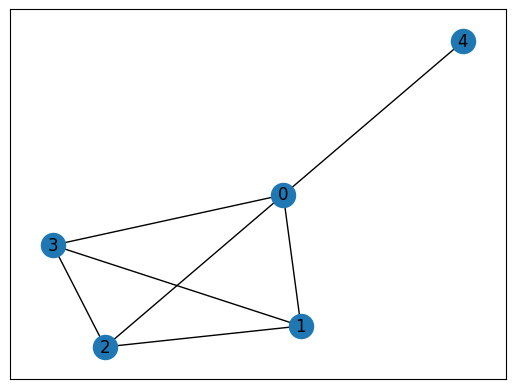

In [6]:
problem.display_graph()

## Utility Class

In [61]:
from qiskit.quantum_info import Statevector, Operator, DensityMatrix, partial_trace, entropy
from IPython.display import display
from qiskit import QuantumCircuit, transpile
from qiskit_aer.backends import AerSimulator
from qiskit.visualization import plot_histogram

import numpy as np

class Utils:

    @staticmethod
    def test_label_circuit(label: str, instruction: QuantumCircuit | Operator) -> None:
        test_vector_input = Statevector.from_label(label)
        display(test_vector_input.draw("latex", prefix="\psi_{input} = "))

        test_vector_output = test_vector_input.evolve(instruction)
        display(test_vector_output.draw("latex", prefix="\psi_{output} = O \psi_{input} = "))

        return test_vector_output

    @staticmethod
    def is_entangled(state: Statevector, epsilon: float=1e-10) -> bool:
        num_qubits = state.num_qubits
        density_matrix = DensityMatrix(state)

        for qubit in range(num_qubits):
            trace_out = [i for i in range(num_qubits) if i != qubit]
            reduced_dm = partial_trace(density_matrix, trace_out)

            subsystem_entropy = entropy(reduced_dm)

            if subsystem_entropy > epsilon:
                return True

        return False

    @staticmethod
    def simulate(circuit: QuantumCircuit, num_shots: int = 1024, display_circuit: bool = False) -> None:
        circuit.measure(list(range(problem.num_vertices * 2)), list(range(problem.num_vertices * 2)))

        backend = AerSimulator()
        circuit = transpile(circuit, backend=backend)

        if display_circuit:
            display(circuit.draw("mpl"))

        counts = backend.run(circuit, shots=num_shots).result().get_counts()
        display(plot_histogram(counts, figsize=(15, 8)))

    @staticmethod
    def get_num_iter(num_qubits: int | None = None, num_states: int | None = None, num_solutions: int = None) -> int:
        if num_solutions is None:
            num_solutions = 1

        if num_states is None:
            num_states = 2 ** num_qubits

        return int(np.floor((np.pi / 4) * np.sqrt(num_states / num_solutions)))

## Grover's Search Class

In [62]:
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator, Statevector
from itertools import product
import numpy as np
import textwrap

class GroversSearch:

    @staticmethod
    def ORGate() -> Operator:
        circuit = QuantumCircuit(3)

        circuit.x(0)
        circuit.x(1)
        circuit.ccx(control_qubit1=0,
                    control_qubit2=1,
                    target_qubit=2)
        circuit.x(0)
        circuit.x(1)
        circuit.x(2)

        return Operator(circuit)

    @staticmethod
    def similarity_operator() -> Operator:
        circuit = QuantumCircuit(5)

        circuit.cx(0, 2)
        circuit.cx(1, 3)

        circuit.append(GroversSearch.ORGate(), [2, 3, 4])

        circuit.cx(0, 2)
        circuit.cx(1, 3)

        return Operator(circuit)

    @staticmethod
    def grover_oracle(num_qubits: int, num_vertices: int, edges_list: list[tuple[int]]) -> Operator:
        ancilla_qubits = list(range(num_vertices * 2, num_qubits - 1))

        vertices = list(range(num_vertices * 2))
        vertex_qubits = [[vertices[i], vertices[i + 1]]
                        for i in range(0, len(range(len(vertices))), 2)]

        sim_op = GroversSearch.similarity_operator()
        circuit = QuantumCircuit(num_qubits)

        for edge_index, edge_nodes in enumerate(edges_list):
            apply_to_qubits = vertex_qubits[edge_nodes[0]] + vertex_qubits[edge_nodes[1]] + [ancilla_qubits[edge_index]]
            circuit.append(sim_op, apply_to_qubits)

        circuit.h(num_qubits - 1)
        circuit.mcx(ancilla_qubits, num_qubits - 1)
        circuit.h(num_qubits - 1)

        for edge_index, edge_nodes in enumerate(edges_list):
            apply_to_qubits = vertex_qubits[edge_nodes[0]] + vertex_qubits[edge_nodes[1]] + [ancilla_qubits[edge_index]]
            circuit.append(sim_op, apply_to_qubits)

        return Operator(circuit)

    @staticmethod
    def circuit_initializer(num_qubits: int, restrict_states: list[str]) -> QuantumCircuit:
        circuit = QuantumCircuit(num_qubits)

        bin_seq = ["".join(seq) for seq in product("01", repeat=num_qubits)]
        bin_seq = list(map(lambda x: textwrap.wrap(x, 2), bin_seq))

        allowed_states = [state for state in bin_seq if not any(rs in state for rs in restrict_states)]
        allowed_states = list(map(lambda x: "".join(x), allowed_states))

        amplitude = len(allowed_states)
        bin_seq = list(map(lambda x: "".join(x), bin_seq))

        state_vec_amplitudes = [1 / np.sqrt(amplitude) if state in allowed_states else 0 for state in bin_seq]
        psi_0 = Statevector(state_vec_amplitudes)

        if psi_0.is_valid():
            circuit.initialize(psi_0)

        circuit = transpile(circuit)
        circuit.data = [inst for inst in circuit.data if inst.operation.name != "reset"]

        return Operator(circuit.to_gate())

    @staticmethod
    def diffusion_operator(num_vertices: int, custom_initializer: Operator = None) -> Operator:
        circuit = QuantumCircuit((num_vertices * 2) + 1)

        if custom_initializer is not None:
            circuit.append(custom_initializer, list(range(num_vertices * 2)))
        else:
            circuit.h(list(range(num_vertices * 2)))

        circuit.h(-1)

        vector_input = Statevector.from_instruction(circuit)
        vector_outer = np.outer(vector_input, vector_input)

        return Operator((2 * vector_outer) - np.eye(vector_outer.shape[0]))

## Apply Grover's Search on the Problem (with all State Space, i.e., Super-Position)

### One Iteration

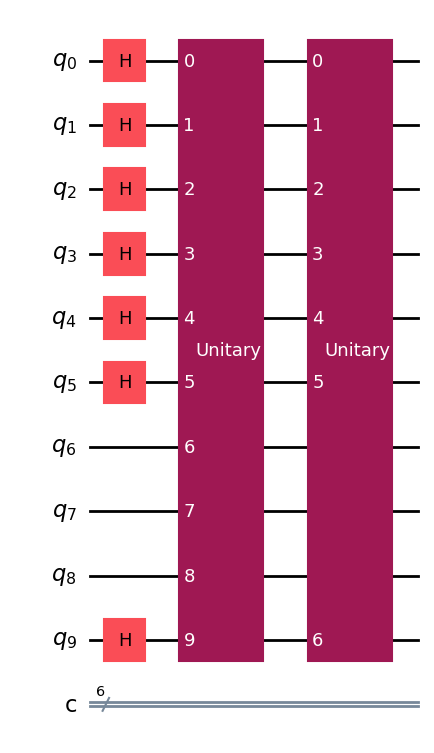

In [63]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

q_regs = QuantumRegister(problem.num_qubits, name='q')
c_regs = ClassicalRegister(problem.num_vertices * 2, name='c')

oracle_operator = GroversSearch.grover_oracle(num_qubits=problem.num_qubits,
                                num_vertices=num_vertices, edges_list=edges_list)
diffusion_op = GroversSearch.diffusion_operator(num_vertices=num_vertices)

circuit = QuantumCircuit(q_regs, c_regs)

circuit.h(q_regs[:num_vertices * 2])
circuit.h(q_regs[-1])

circuit.append(oracle_operator, q_regs)
circuit.append(diffusion_op, list(range(num_vertices * 2)) + [problem.num_qubits - 1])

circuit.draw("mpl")

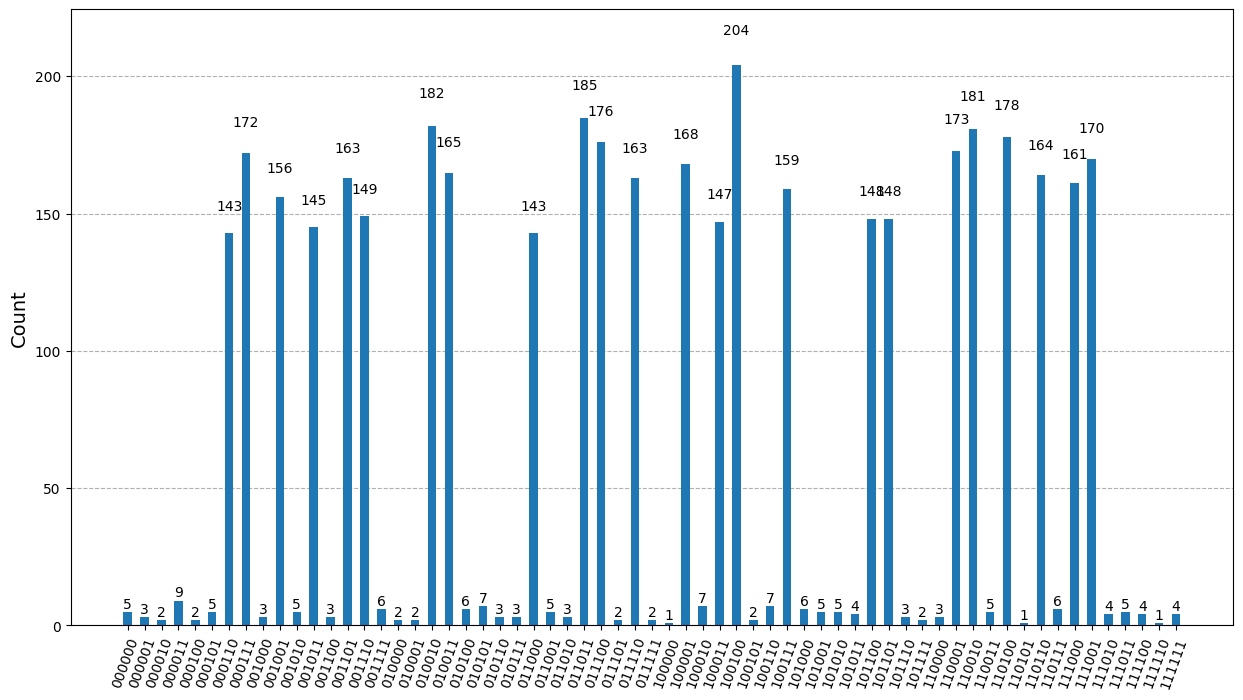

In [64]:
Utils.simulate(circuit=circuit, num_shots=4096)

### Using Number of Iterations

Number of Iterations: 1


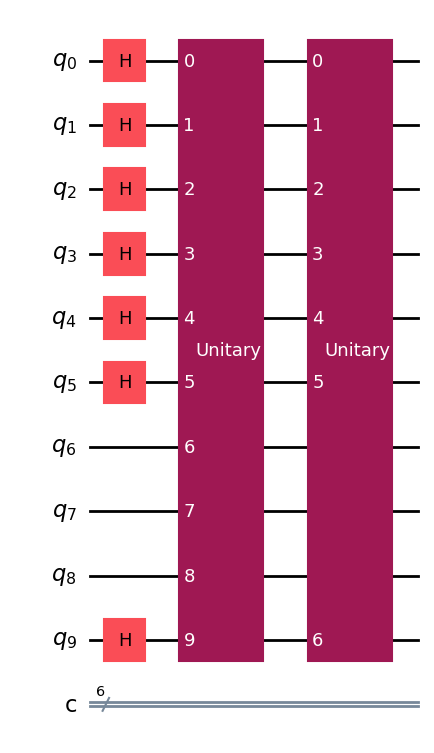

In [35]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

num_iter = Utils.get_num_iter(num_qubits=(problem.num_qubits - problem.num_edges), num_solutions=24)
print(f"Number of Iterations: {num_iter}")

q_regs = QuantumRegister(problem.num_qubits, name='q')
c_regs = ClassicalRegister(problem.num_vertices * 2, name='c')

oracle_operator = GroversSearch.grover_oracle(num_qubits=problem.num_qubits,
                                num_vertices=num_vertices, edges_list=edges_list)
diffusion_op = GroversSearch.diffusion_operator(num_vertices=num_vertices)

circuit = QuantumCircuit(q_regs, c_regs)

circuit.h(q_regs[:num_vertices * 2])
circuit.h(q_regs[-1])

for _ in range(num_iter):
    circuit.append(oracle_operator, q_regs)
    circuit.append(diffusion_op, list(range(num_vertices * 2)) + [problem.num_qubits - 1])

circuit.draw("mpl")

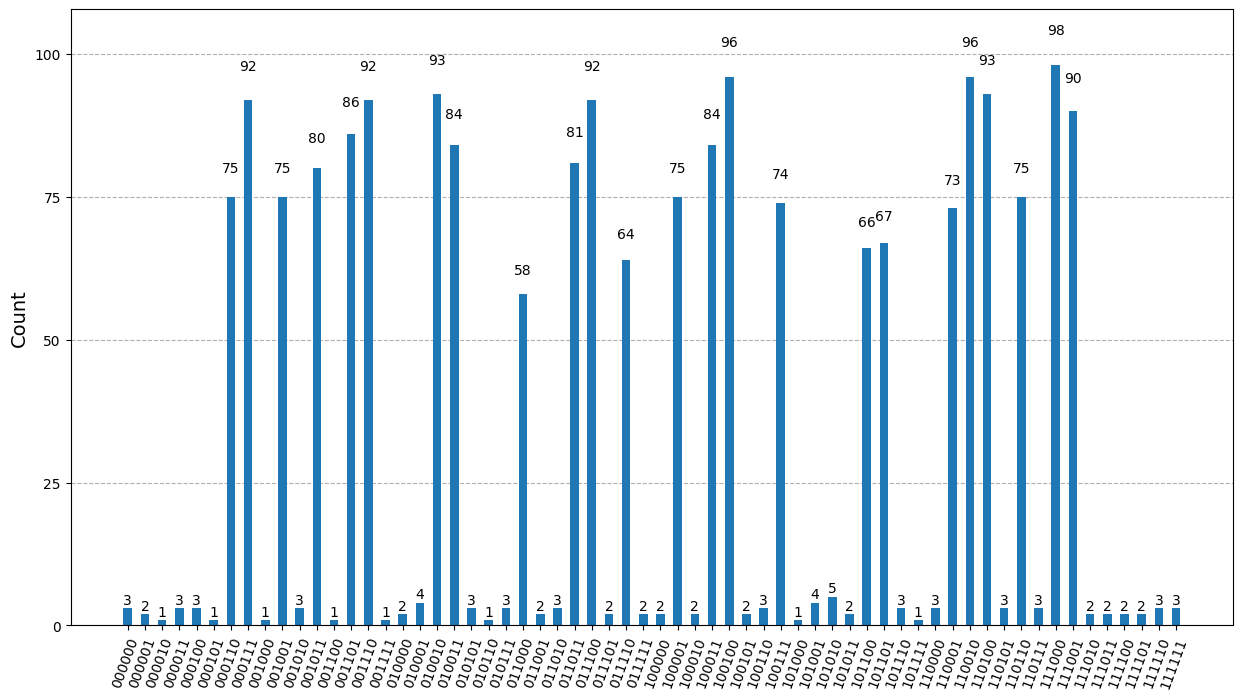

In [36]:
Utils.simulate(circuit=circuit, num_shots=2048)

## Apply Grover's Search on the Problem (with Ristricted State Space, i.e., Only Valid Colors)

### One Iteration

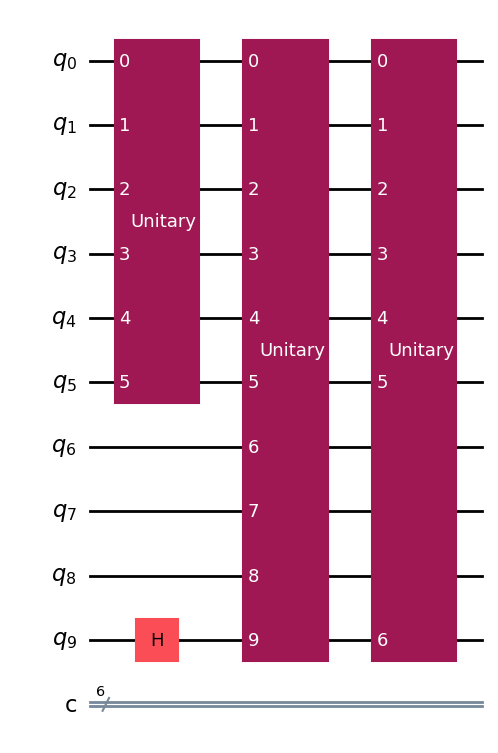

In [65]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

q_regs = QuantumRegister(problem.num_qubits, name='q')
c_regs = ClassicalRegister(problem.num_vertices * 2, name='c')

ristrict_operator = GroversSearch.circuit_initializer(num_qubits=(num_vertices * 2), restrict_states=["11"])
oracle_operator = GroversSearch.grover_oracle(num_qubits=problem.num_qubits,
                                num_vertices=num_vertices, edges_list=edges_list)
diffusion_op = GroversSearch.diffusion_operator(num_vertices=num_vertices, custom_initializer=ristrict_operator)

circuit = QuantumCircuit(q_regs, c_regs)

circuit.append(ristrict_operator, list(range(num_vertices * 2)))
circuit.h(q_regs[-1])

circuit.append(oracle_operator, q_regs)
circuit.append(diffusion_op, list(range(num_vertices * 2)) + [problem.num_qubits - 1])

circuit.draw("mpl")

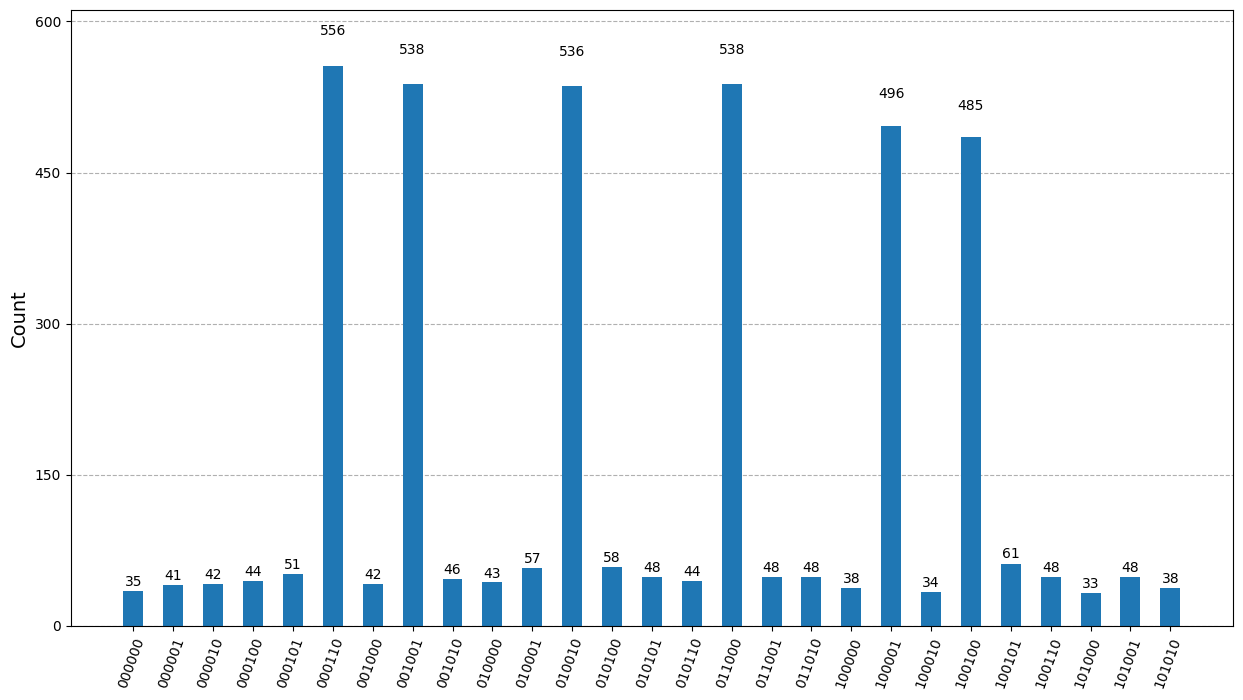

In [66]:
Utils.simulate(circuit=circuit, num_shots=4096)

### More than One Iteration

Number of Iterations: 2


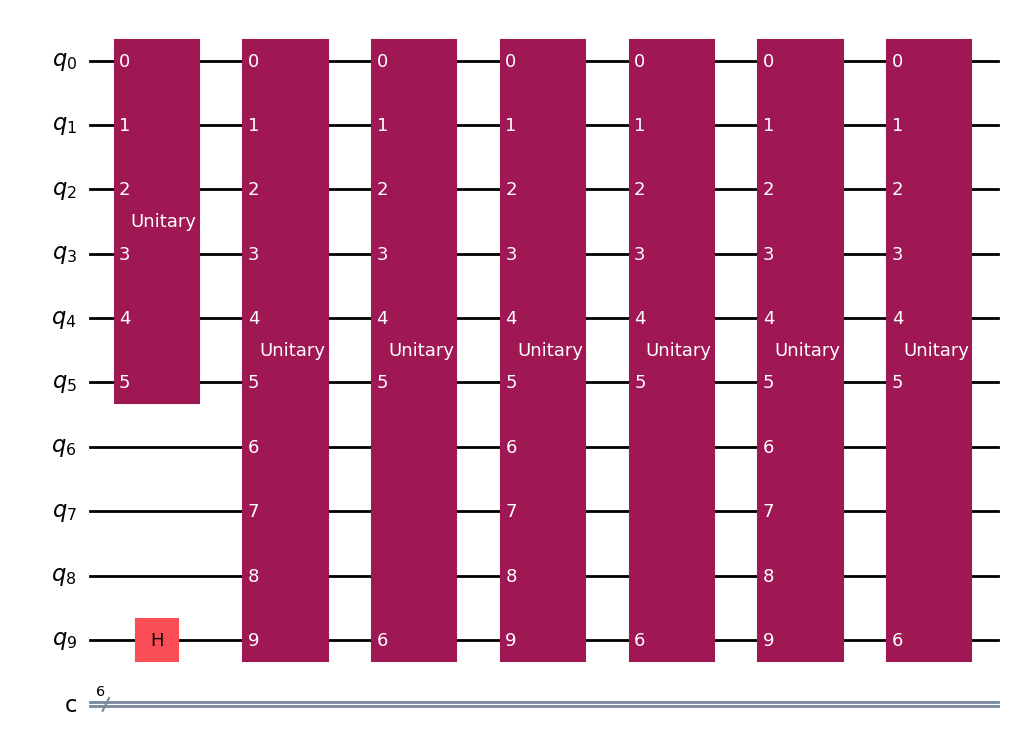

In [69]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

num_iter = Utils.get_num_iter(num_qubits=(problem.num_qubits - problem.num_edges), num_solutions=12)
print(f"Number of Iterations: {num_iter}")

q_regs = QuantumRegister(problem.num_qubits, name='q')
c_regs = ClassicalRegister(problem.num_vertices * 2, name='c')

ristrict_operator = GroversSearch.circuit_initializer(num_qubits=(num_vertices * 2), restrict_states=["11"])
oracle_operator = GroversSearch.grover_oracle(num_qubits=problem.num_qubits,
                                num_vertices=num_vertices, edges_list=edges_list)
diffusion_op = GroversSearch.diffusion_operator(num_vertices=num_vertices, custom_initializer=ristrict_operator)

circuit = QuantumCircuit(q_regs, c_regs)

circuit.append(ristrict_operator, list(range(num_vertices * 2)))
circuit.h(q_regs[-1])

for _ in range(3):
    circuit.append(oracle_operator, q_regs)
    circuit.append(diffusion_op, list(range(num_vertices * 2)) + [problem.num_qubits - 1])

circuit.draw("mpl")

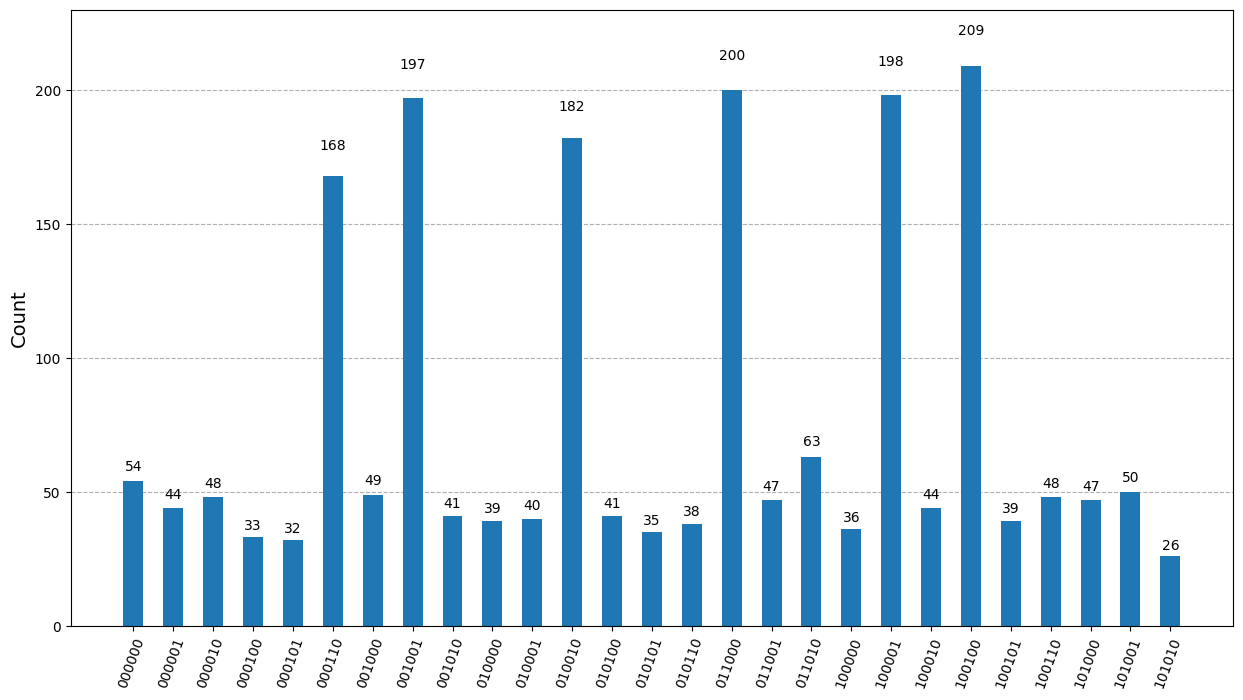

In [70]:
Utils.simulate(circuit=circuit, num_shots=2048)